# LSTM - Standard Keras Embedding
Reference: https://towardsdatascience.com/word-bags-vs-word-sequences-for-text-classification-e0222c21d2ec

Import Libraries:

In [1]:
import numpy as np
import os
import time
from datetime import datetime
import pandas as pd
import json
import re
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import random as rn
import keras
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

startTime = time.time()
print("Tensor Flow Version: ",tf.__version__)

Using TensorFlow backend.


Tensor Flow Version:  2.2.0-rc2


In [2]:
#All this for reproducibility
np.random.seed(1)
rn.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(112)

In [3]:
# Build the corpus and sequences
labelToName = { 0 : 'Rejected', 1 : 'Allowed' }
namesInLabelOrder = ['Rejected', 'Allowed']

#Read
os.chdir('D:\\PhD\\Dataset\\Encoded\\Datasets')
readFromFile = np.loadtxt('EncodedCriminalBailApplication.csv', delimiter=',')
# print the array
print("\nTest Read :",readFromFile[1])

Xencoded=readFromFile[:,:-1]
print("\nXencoded :",Xencoded[1])
labels=readFromFile[:,-1]
print("\nlabels :",labels[1])




Test Read : [   0.    0.    0. ...  358. 1575.    0.]

Xencoded : [   0.    0.    0. ...   18.  358. 1575.]

labels : 0.0


In [4]:
#nWords=len(kTokenizer.word_index)
nWords=10203
maxsequenceLength=1503
EMBEDDING_DIM=200

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1).split(Xencoded, labels)
train_indices, test_indices = next(sss)
print(np.shape(train_indices))
print(np.shape(test_indices))

train_x = Xencoded[train_indices]
test_x = Xencoded[test_indices]
train_labels = keras.utils.to_categorical(labels[train_indices], len(labelToName))
test_labels = keras.utils.to_categorical(labels[test_indices], len(labelToName))

(309,)
(78,)


In [6]:
# Build the LSTM model
def getModel():
    units1, units2 = int (nWords/4), int (nWords/8)
    model = keras.models.Sequential()
    model.add(keras.layers.embeddings.Embedding(input_dim = nWords+1,output_dim=EMBEDDING_DIM,input_length=maxsequenceLength, trainable=True))               
    model.add(keras.layers.LSTM(units = units2, return_sequences =False))                              
    model.add(keras.layers.Dense(len(labelToName), activation ='softmax'))                           
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
    return model

In [7]:
# Train and test over multiple train/validation sets
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=False)                         
sss2 = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=1).split(train_x, train_labels)          
results={}
for i in range(1):
    train_indices_2, val_indices = next(sss2)
    model = getModel()
    model.summary()
    history=model.fit(x=train_x[train_indices_2], y=train_labels[train_indices_2], epochs=50, batch_size=32, shuffle=True, validation_data = (train_x[val_indices], train_labels[val_indices]), verbose=2, callbacks=[early_stop], use_multiprocessing=True)
    test_loss, test_accuracy = model.evaluate(test_x, test_labels, verbose=2)                                
    print ("\ntest_loss:",test_loss, "\ntest_accuracy:",test_accuracy)
    predicted = model.predict(test_x, verbose=2)
    predicted_labels = predicted.argmax(axis=1)        
    print ("\n\nConfusion Matrix:\n",confusion_matrix(labels[test_indices], predicted_labels))
    print ("\n\nClassification Report:\n\n",classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder))
    result={}
    result['confusion_matrix'] = confusion_matrix(labels[test_indices], predicted_labels).tolist()
    result['classification_report'] = classification_report(labels[test_indices], predicted_labels, digits=4, target_names=namesInLabelOrder, output_dict=True)
    results[i] = result
os.chdir('D:\\PhD\\Dataset\\Results\\Paper2')
filename = 'LSTM-Keras-EMB-'+time.strftime("%d-%m-%Y-%H-%M-%S")+'.json'
f = open (filename,'w')
out = json.dumps(results, ensure_ascii=True)
f.write(out)
f.close()

endTime = time.time()
hours, rem = divmod(endTime-startTime, 3600)
minutes, seconds = divmod(rem, 60)
print("\n\nTotal time taken: ")
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1503, 200)         2040800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1275)              7527600   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2552      
Total params: 9,570,952
Trainable params: 9,570,952
Non-trainable params: 0
_________________________________________________________________


c:\users\admin\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 247 samples, validate on 62 samples
Epoch 1/50
 - 768s - loss: 0.8955 - acc: 0.7328 - val_loss: 0.5946 - val_acc: 0.7903
Epoch 2/50
 - 670s - loss: 0.6290 - acc: 0.7854 - val_loss: 0.5259 - val_acc: 0.7903
Epoch 3/50
 - 613s - loss: 0.4837 - acc: 0.8259 - val_loss: 0.4000 - val_acc: 0.7903
Epoch 4/50
 - 638s - loss: 0.2867 - acc: 0.8381 - val_loss: 0.3030 - val_acc: 0.8548
Epoch 5/50
 - 578s - loss: 0.2296 - acc: 0.9676 - val_loss: 0.3134 - val_acc: 0.8710
Epoch 6/50
 - 567s - loss: 0.1510 - acc: 0.9595 - val_loss: 0.2451 - val_acc: 0.8548
Epoch 7/50
 - 650s - loss: 0.2547 - acc: 0.9231 - val_loss: 0.3077 - val_acc: 0.8387
Epoch 8/50
 - 593s - loss: 0.1030 - acc: 0.9919 - val_loss: 0.1731 - val_acc: 0.9194
Epoch 9/50
 - 578s - loss: 0.0307 - acc: 0.9960 - val_loss: 0.3295 - val_acc: 0.8871
Epoch 10/50
 - 572s - loss: 0.0093 - acc: 1.0000 - val_loss: 0.1797 - val_acc: 0.9355
Epoch 11/50
 - 575s - loss: 0.0066 - acc: 0.9960 - val_loss: 0.4414 - val_acc: 0.8387
Epoch 12/50
 - 578

In [12]:
print(len(history.history['acc']))
print(len(history.history['val_acc']))
print(len(history.history['loss']))
print(len(history.history['val_loss']))
print(len(history.history['acc']))

13
13
13
13
13


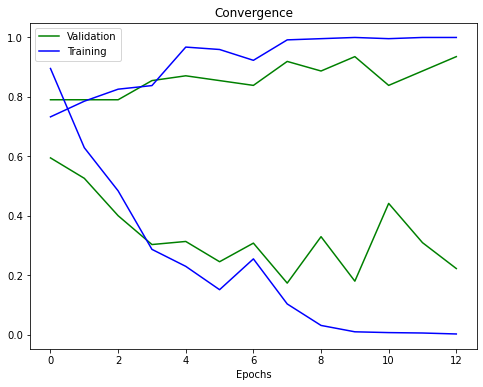

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
subplot = fig.add_subplot(1, 1, 1)

loss_train = history.history['loss']
loss_val = history.history['val_loss']

acc_train = history.history['acc']
acc_val = history.history['val_acc']

epochs = range(0,len(history.history['val_acc']))

subplot.plot(epochs,acc_val,color='g', label='Validation')
subplot.plot(epochs,loss_val,color='g')
subplot.plot(epochs,acc_train,color='b')
subplot.plot(epochs,loss_train,color='b', label='Training')

plt.title('Convergence')
plt.xlabel('Epochs')
#subplot.legend(loc='upper left', prop={'size': 9})
plt.legend()
plt.show()

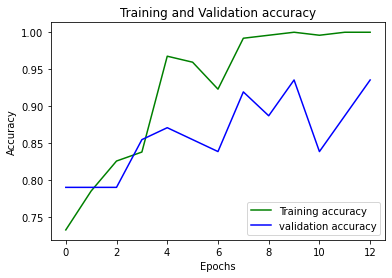

In [14]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(0,len(history.history['val_acc']))
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

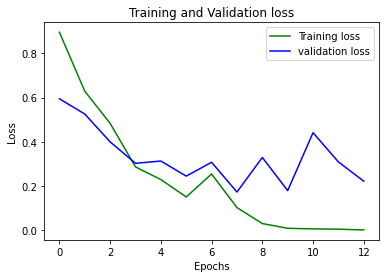

In [15]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,len(history.history['val_loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()